In [3]:
import pandas as pd
import re
import torch
import torch.nn as nn
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import vocab
from itertools import permutations
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# -----------------------------
# 1. 데이터 불러오기 및 준비
# -----------------------------
df = pd.read_csv("train.csv")  # ID 컬럼 포함되어 있음

# 문장 묶기 및 정답 레이블 생성
perm_list = list(permutations([0, 1, 2, 3]))
df["sentences"] = df.apply(lambda row: [row[f"sentence_{i}"] for i in range(4)], axis=1)
df["label"] = df.apply(lambda row: [row[f"answer_{i}"] for i in range(4)], axis=1)
df["class_id"] = df["label"].apply(lambda x: perm_list.index(tuple(x)))

# ID 백업
df_ids = df["ID"].tolist()
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=False)
val_ids = val_df["ID"].tolist()

# -----------------------------
# 2. 토크나이저 및 Vocab 생성
# -----------------------------
def tokenize(text):
    return re.findall(r'\w+', text.lower())

all_tokens = []
for sents in df["sentences"]:
    for sent in sents:
        all_tokens.extend(tokenize(sent))

counter = Counter(all_tokens)
vocab_obj = vocab(counter, specials=['<pad>', '<unk>'])
vocab_obj.set_default_index(vocab_obj['<unk>'])

def numericalize(text):
    return [vocab_obj[token] for token in tokenize(text)]

# -----------------------------
# 3. Dataset 정의
# -----------------------------
class SentenceOrderDataset(Dataset):
    def __init__(self, df, max_len=30):
        self.sentences = df["sentences"].tolist()
        self.labels = df["class_id"].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def pad(self, tokens):
        tokens = tokens[:self.max_len]
        return tokens + [vocab_obj['<pad>']] * (self.max_len - len(tokens))

    def __getitem__(self, idx):
        encoded = [self.pad(numericalize(sent)) for sent in self.sentences[idx]]
        return torch.tensor(encoded), torch.tensor(self.labels[idx])

train_dataset = SentenceOrderDataset(train_df)
val_dataset = SentenceOrderDataset(val_df)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# -----------------------------
# 4. 모델 정의 (LSTM 기반)
# -----------------------------
class OrderPredictionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab_obj['<pad>'])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 24)
        )

    def forward(self, x):
        reps = []
        for i in range(4):
            emb = self.embed(x[:, i])
            _, (h_n, _) = self.lstm(emb)
            reps.append(h_n[-1])
        concat = torch.cat(reps, dim=1)
        return self.fc(concat)

# -----------------------------
# 5. 학습 루프 + Validation Accuracy
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OrderPredictionModel(len(vocab_obj)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation Accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            out = model(x_val)
            pred = out.argmax(dim=1)
            correct += (pred == y_val).sum().item()
            total += y_val.size(0)

    val_acc = correct / total
    print(f"Epoch {epoch+1:2d} | Loss: {total_loss / len(train_loader):.4f} | Val Acc: {val_acc:.4f}")

# -----------------------------
# 6. 예측 및 제출 파일 생성
# -----------------------------
model.eval()
preds = []
with torch.no_grad():
    for x, _ in val_loader:
        x = x.to(device)
        out = model(x)
        pred_class = out.argmax(dim=1)
        preds.extend(pred_class.cpu().tolist())

# 분포 확인
print("🔎 예측 class 분포:", Counter(preds))

final_orders = [perm_list[i] for i in preds]
submission = pd.DataFrame({
    "ID": val_ids,
    "answer_0": [p[0] for p in final_orders],
    "answer_1": [p[1] for p in final_orders],
    "answer_2": [p[2] for p in final_orders],
    "answer_3": [p[3] for p in final_orders]
})
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv 저장 완료 (ID 포함)")


Epoch  1 | Loss: 3.1792 | Val Acc: 0.0380
Epoch  2 | Loss: 2.8935 | Val Acc: 0.2772
Epoch  3 | Loss: 1.4808 | Val Acc: 0.3492
Epoch  4 | Loss: 1.0730 | Val Acc: 0.4524
Epoch  5 | Loss: 0.7922 | Val Acc: 0.4674
Epoch  6 | Loss: 0.5649 | Val Acc: 0.4443
Epoch  7 | Loss: 0.3617 | Val Acc: 0.4728
Epoch  8 | Loss: 0.2182 | Val Acc: 0.4891
Epoch  9 | Loss: 0.1222 | Val Acc: 0.4864
Epoch 10 | Loss: 0.0938 | Val Acc: 0.5000
Epoch 11 | Loss: 0.0814 | Val Acc: 0.4932
Epoch 12 | Loss: 0.0533 | Val Acc: 0.4878
Epoch 13 | Loss: 0.0386 | Val Acc: 0.4742
Epoch 14 | Loss: 0.0389 | Val Acc: 0.4986
Epoch 15 | Loss: 0.0567 | Val Acc: 0.4688
Epoch 16 | Loss: 0.0527 | Val Acc: 0.4837
Epoch 17 | Loss: 0.0455 | Val Acc: 0.5000
Epoch 18 | Loss: 0.0368 | Val Acc: 0.4878
Epoch 19 | Loss: 0.0490 | Val Acc: 0.5000
Epoch 20 | Loss: 0.0454 | Val Acc: 0.4905
🔎 예측 class 분포: Counter({1: 46, 16: 45, 10: 42, 20: 40, 23: 38, 9: 38, 3: 37, 8: 36, 12: 35, 0: 33, 11: 33, 2: 30, 15: 29, 19: 29, 5: 27, 17: 26, 14: 25, 4: 24, 

## 결과는 제대로 나온거 같음. 하지만 정답률이 절반에 불과함. 더 높일 필요가 있어서 코드를 수정했음.

In [4]:
print(val_df["ID"].head(10).tolist())

['TRAIN_6615', 'TRAIN_6616', 'TRAIN_6617', 'TRAIN_6618', 'TRAIN_6619', 'TRAIN_6620', 'TRAIN_6621', 'TRAIN_6622', 'TRAIN_6623', 'TRAIN_6624']


import pandas as pd
import re
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchtext.vocab import vocab
from itertools import permutations
from sklearn.model_selection import train_test_split

# 1. 데이터 불러오기 및 전처리

df = pd.read_csv("train.csv")
perm_list = list(permutations([0, 1, 2, 3]))
df["sentences"] = df.apply(lambda row: [row[f"sentence_{i}"] for i in range(4)], axis=1)
df["label"] = df.apply(lambda row: [row[f"answer_{i}"] for i in range(4)], axis=1)
df["class_id"] = df["label"].apply(lambda x: perm_list.index(tuple(x)))

# Stratified split with shuffle
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    shuffle=True,
    stratify=df["class_id"]
)
val_ids = val_df["ID"].tolist()

# 2. 토크나이징 및 vocab

def tokenize(text):
    return re.findall(r'\w+', text.lower())

all_tokens = []
for sents in df["sentences"]:
    for sent in sents:
        all_tokens.extend(tokenize(sent))

counter = Counter(all_tokens)
vocab_obj = vocab(counter, specials=['<pad>', '<unk>'])
vocab_obj.set_default_index(vocab_obj['<unk>'])

def numericalize(text):
    return [vocab_obj[token] for token in tokenize(text)]

# 3. Dataset 정의

class SentenceOrderDataset(Dataset):
    def __init__(self, df, max_len=30):
        self.sentences = df["sentences"].tolist()
        self.labels = df["class_id"].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def pad(self, tokens):
        tokens = tokens[:self.max_len]
        return tokens + [vocab_obj['<pad>']] * (self.max_len - len(tokens))

    def __getitem__(self, idx):
        encoded = [self.pad(numericalize(sent)) for sent in self.sentences[idx]]
        return torch.tensor(encoded), torch.tensor(self.labels[idx])

train_dataset = SentenceOrderDataset(train_df)
val_dataset = SentenceOrderDataset(val_df)

# 4. Sampler로 클래스 불균형 대응
class_counts = Counter(train_df["class_id"])
sample_weights = [1.0 / class_counts[c] for c in train_df["class_id"]]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,
    drop_last=True
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 5. 모델 정의 (Dropout 추가)

class OrderPredictionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab_obj['<pad>'])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 4, 256),
            nn.ReLU(),
            nn.Linear(256, len(perm_list))
        )

    def forward(self, x):
        reps = []
        for i in range(4):
            emb = self.embed(x[:, i])
            _, (h_n, _) = self.lstm(emb)
            reps.append(h_n[-1])
        concat = torch.cat(reps, dim=1)
        return self.fc(concat)

# 6. 학습 준비

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OrderPredictionModel(len(vocab_obj)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()  # sampler로 imbalance 대응하므로 weight 제거

# 7. 학습 루프 (15 epoch), Train/Val Acc 모니터링

for epoch in range(15):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Train Accuracy
    model.eval()
    train_correct, train_total = 0, 0
    with torch.no_grad():
        for x_tr, y_tr in train_loader:
            x_tr, y_tr = x_tr.to(device), y_tr.to(device)
            out_tr = model(x_tr)
            pred_tr = out_tr.argmax(dim=1)
            train_correct += (pred_tr == y_tr).sum().item()
            train_total += y_tr.size(0)
    train_acc = train_correct / train_total

    # Validation Accuracy
    correct, total = 0, 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            out = model(x_val)
            pred = out.argmax(dim=1)
            correct += (pred == y_val).sum().item()
            total += y_val.size(0)
    val_acc = correct / total

    print(f"Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# 8. 예측 및 제출

model.eval()
preds = []
with torch.no_grad():
    for x, _ in val_loader:
        x = x.to(device)
        out = model(x)
        pred_class = out.argmax(dim=1)
        preds.extend(pred_class.cpu().tolist())

print("🔍 예측 class 분포:", Counter(preds))

final_orders = [perm_list[i] for i in preds]
submission = pd.DataFrame({
    "ID": val_ids,
    "answer_0": [p[0] for p in final_orders],
    "answer_1": [p[1] for p in final_orders],
    "answer_2": [p[2] for p in final_orders],
    "answer_3": [p[3] for p in final_orders]
})
submission.to_csv("submission1.csv", index=False)
print("✅ submission.csv 저장 완료")


## 코드 이상함. 에포크 수가 증가해도 손실은 줄지 않고 정답률도 똑같음.

In [2]:
import pandas as pd
import re
import torch
import torch.nn as nn
from collections import Counter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchtext.vocab import vocab
from itertools import permutations
from sklearn.model_selection import train_test_split

# 1. 데이터 로드 및 전처리

df = pd.read_csv("train.csv")
perm_list = list(permutations([0, 1, 2, 3]))
df["sentences"] = df.apply(lambda r: [r[f"sentence_{i}"] for i in range(4)], axis=1)
df["label"] = df.apply(lambda r: [r[f"answer_{i}"] for i in range(4)], axis=1)
df["class_id"] = df["label"].apply(lambda x: perm_list.index(tuple(x)))

# Stratified split & shuffle
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    shuffle=True,
    stratify=df["class_id"]
)
val_ids = val_df["ID"].tolist()

# 2. 토크나이즈 & Vocab

def tokenize(text): return re.findall(r"\w+", text.lower())
all_tokens = [t for sents in df["sentences"] for sent in sents for t in tokenize(sent)]
counter = Counter(all_tokens)
vocab_obj = vocab(counter, specials=["<pad>", "<unk>"])
vocab_obj.set_default_index(vocab_obj["<unk>"])

def numericalize(text): return [vocab_obj[w] for w in tokenize(text)]

# 3. Dataset

class SentenceOrderDataset(Dataset):
    def __init__(self, df, max_len=30):
        self.sentences = df["sentences"].tolist()
        self.labels = df["class_id"].tolist()
        self.max_len = max_len
    def __len__(self): return len(self.sentences)
    def pad(self, tokens):
        t = tokens[:self.max_len]
        return t + [vocab_obj["<pad>"]] * (self.max_len - len(t))
    def __getitem__(self, idx):
        enc = [self.pad(numericalize(s)) for s in self.sentences[idx]]
        return torch.tensor(enc), torch.tensor(self.labels[idx])

train_ds = SentenceOrderDataset(train_df)
val_ds   = SentenceOrderDataset(val_df)

# 4. Sampler for imbalance
counts = Counter(train_df["class_id"])
weights = [1.0/counts[c] for c in train_df["class_id"]]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)

# 5. Model

class OrderPredictionModel(nn.Module):
    def __init__(self, vocab_size, e_dim=256, h_dim=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, e_dim, padding_idx=vocab_obj["<pad>"])
        self.lstm  = nn.LSTM(e_dim, h_dim, batch_first=True)
        self.fc   = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(h_dim*4, 256),
            nn.ReLU(),
            nn.Linear(256, len(perm_list))
        )
    def forward(self, x):
        reps = []
        for i in range(4):
            emb = self.embed(x[:,i])
            _, (h,_)= self.lstm(emb)
            reps.append(h[-1])
        out = torch.cat(reps, dim=1)
        return self.fc(out)

# 6. Training setup with LR scheduler & clipping

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OrderPredictionModel(len(vocab_obj)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

epochs = 15
for ep in range(1, epochs+1):
    model.train()
    total_loss = 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_tr_loss = total_loss/len(train_loader)

    # validation
    model.eval()
    val_loss, correct, total = 0,0,0
    with torch.no_grad():
        for x_val,y_val in val_loader:
            x_val,y_val = x_val.to(device), y_val.to(device)
            out = model(x_val)
            val_loss += criterion(out, y_val).item()
            preds = out.argmax(dim=1)
            correct += (preds==y_val).sum().item()
            total += y_val.size(0)
    avg_val_loss = val_loss/len(val_loader)
    val_acc = correct/total
    scheduler.step(avg_val_loss)

    print(f"Epoch {ep:02d} | Train Loss {avg_tr_loss:.4f} | Val Loss {avg_val_loss:.4f} | Val Acc {val_acc:.4f}")

# 7. Inference & Submit
model.eval()
preds=[]
with torch.no_grad():
    for x,_ in val_loader:
        x = x.to(device)
        out = model(x)
        preds.extend(out.argmax(dim=1).cpu().tolist())

orders = [perm_list[i] for i in preds]
sub = pd.DataFrame({"ID": val_ids,
                    "answer_0":[o[0] for o in orders],
                    "answer_1":[o[1] for o in orders],
                    "answer_2":[o[2] for o in orders],
                    "answer_3":[o[3] for o in orders]})
sub.to_csv("submission1.csv", index=False)
print("Submission saved.")

Epoch 01 | Train Loss 3.1792 | Val Loss 3.1788 | Val Acc 0.0435
Epoch 02 | Train Loss 3.1781 | Val Loss 3.1789 | Val Acc 0.0435
Epoch 03 | Train Loss 3.1787 | Val Loss 3.1788 | Val Acc 0.0408
Epoch 04 | Train Loss 3.1755 | Val Loss 3.1150 | Val Acc 0.0652
Epoch 05 | Train Loss 2.7979 | Val Loss 2.3478 | Val Acc 0.1753
Epoch 06 | Train Loss 1.9286 | Val Loss 1.7776 | Val Acc 0.2880
Epoch 07 | Train Loss 1.5832 | Val Loss 1.6774 | Val Acc 0.3179
Epoch 08 | Train Loss 1.4143 | Val Loss 1.6369 | Val Acc 0.3329
Epoch 09 | Train Loss 1.3071 | Val Loss 1.5388 | Val Acc 0.3397
Epoch 10 | Train Loss 1.1618 | Val Loss 1.5179 | Val Acc 0.3886
Epoch 11 | Train Loss 1.0593 | Val Loss 1.5083 | Val Acc 0.3995
Epoch 12 | Train Loss 0.9624 | Val Loss 1.5764 | Val Acc 0.4062
Epoch 13 | Train Loss 0.8478 | Val Loss 1.6251 | Val Acc 0.4321
Epoch 14 | Train Loss 0.7445 | Val Loss 1.7429 | Val Acc 0.4266
Epoch 15 | Train Loss 0.6517 | Val Loss 1.7156 | Val Acc 0.4171
Submission saved.


In [3]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.show()

plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs,   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.show()

NameError: name 'train_losses' is not defined

Epoch 01 | Train Loss 3.1791 | Val Loss 3.1782 | Val Acc 0.0394
Epoch 02 | Train Loss 3.1787 | Val Loss 3.1783 | Val Acc 0.0394
Epoch 03 | Train Loss 3.1785 | Val Loss 3.1788 | Val Acc 0.0394
Epoch 04 | Train Loss 3.1786 | Val Loss 3.1783 | Val Acc 0.0394
Epoch 05 | Train Loss 3.1741 | Val Loss 3.1434 | Val Acc 0.0611
Epoch 06 | Train Loss 3.0355 | Val Loss 2.9566 | Val Acc 0.0951
Epoch 07 | Train Loss 2.8013 | Val Loss 2.7584 | Val Acc 0.1264
Epoch 08 | Train Loss 2.6315 | Val Loss 2.6382 | Val Acc 0.1413
Epoch 09 | Train Loss 2.3915 | Val Loss 2.2845 | Val Acc 0.2201
Epoch 10 | Train Loss 2.0349 | Val Loss 2.0021 | Val Acc 0.2812
Epoch 11 | Train Loss 1.8164 | Val Loss 1.8681 | Val Acc 0.2880
Epoch 12 | Train Loss 1.7098 | Val Loss 1.7775 | Val Acc 0.3030
Epoch 13 | Train Loss 1.5688 | Val Loss 1.7144 | Val Acc 0.3098
Epoch 14 | Train Loss 1.5064 | Val Loss 1.6568 | Val Acc 0.3166
Epoch 15 | Train Loss 1.4300 | Val Loss 1.6382 | Val Acc 0.3315


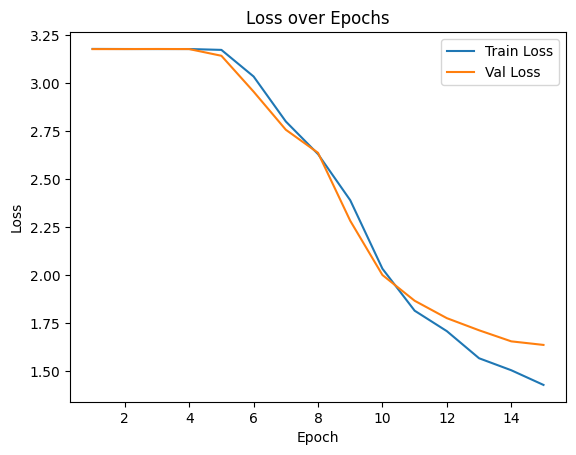

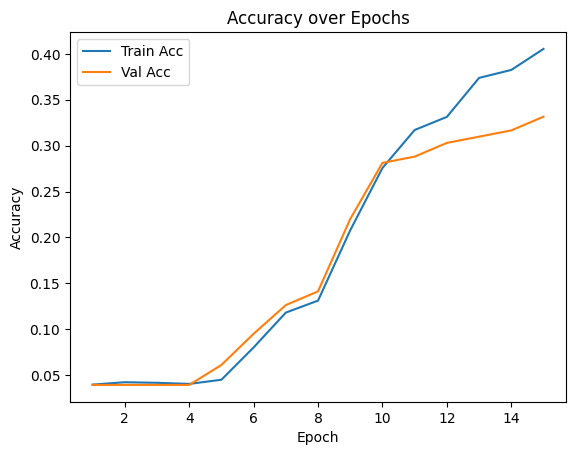

Submission saved.


In [4]:
import pandas as pd
import re
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchtext.vocab import vocab
from itertools import permutations
from sklearn.model_selection import train_test_split

# 1. 데이터 로드 및 전처리

df = pd.read_csv("train.csv")
perm_list = list(permutations([0, 1, 2, 3]))
df["sentences"] = df.apply(lambda r: [r[f"sentence_{i}"] for i in range(4)], axis=1)
df["label"] = df.apply(lambda r: [r[f"answer_{i}"] for i in range(4)], axis=1)
df["class_id"] = df["label"].apply(lambda x: perm_list.index(tuple(x)))

# Stratified split & shuffle
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    shuffle=True,
    stratify=df["class_id"]
)
val_ids = val_df["ID"].tolist()

# 2. 토크나이즈 & Vocab

def tokenize(text): return re.findall(r"\w+", text.lower())
all_tokens = [t for sents in df["sentences"] for sent in sents for t in tokenize(sent)]
counter = Counter(all_tokens)
vocab_obj = vocab(counter, specials=["<pad>", "<unk>"])
vocab_obj.set_default_index(vocab_obj["<unk>"])

def numericalize(text): return [vocab_obj[w] for w in tokenize(text)]

# 3. Dataset

class SentenceOrderDataset(Dataset):
    def __init__(self, df, max_len=30):
        self.sentences = df["sentences"].tolist()
        self.labels = df["class_id"].tolist()
        self.max_len = max_len
    def __len__(self): return len(self.sentences)
    def pad(self, tokens):
        t = tokens[:self.max_len]
        return t + [vocab_obj["<pad>"]] * (self.max_len - len(t))
    def __getitem__(self, idx):
        enc = [self.pad(numericalize(s)) for s in self.sentences[idx]]
        return torch.tensor(enc), torch.tensor(self.labels[idx])

train_ds = SentenceOrderDataset(train_df)
val_ds   = SentenceOrderDataset(val_df)

# 4. Sampler for imbalance
counts = Counter(train_df["class_id"])
weights = [1.0/counts[c] for c in train_df["class_id"]]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

# 5. Model

class OrderPredictionModel(nn.Module):
    def __init__(self, vocab_size, e_dim=256, h_dim=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, e_dim, padding_idx=vocab_obj["<pad>"])
        self.lstm  = nn.LSTM(e_dim, h_dim, batch_first=True)
        self.fc   = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(h_dim*4, 256),
            nn.ReLU(),
            nn.Linear(256, len(perm_list))
        )
    def forward(self, x):
        reps = []
        for i in range(4):
            emb = self.embed(x[:,i])
            _, (h,_) = self.lstm(emb)
            reps.append(h[-1])
        out = torch.cat(reps, dim=1)
        return self.fc(out)

# 6. Training setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OrderPredictionModel(len(vocab_obj)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = 15
for ep in range(1, epochs+1):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    train_acc = correct / total
    avg_tr_loss = total_loss / len(train_loader)

    # validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            out = model(x_val)
            val_loss += criterion(out, y_val).item()
            pred = out.argmax(dim=1)
            correct += (pred == y_val).sum().item()
            total += y_val.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    scheduler.step(avg_val_loss)

    train_losses.append(avg_tr_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {ep:02d} | Train Loss {avg_tr_loss:.4f} | Val Loss {avg_val_loss:.4f} | Val Acc {val_acc:.4f}")

# 7. 시각화

epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.title('Loss over Epochs')
plt.show()

plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, val_accs, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.title('Accuracy over Epochs')
plt.show()

# 8. Inference & Submit
model.eval()
preds = []
with torch.no_grad():
    for x, _ in val_loader:
        x = x.to(device)
        out = model(x)
        preds.extend(out.argmax(dim=1).cpu().tolist())

orders = [perm_list[i] for i in preds]
sub = pd.DataFrame({"ID": val_ids,
                    "answer_0":[o[0] for o in orders],
                    "answer_1":[o[1] for o in orders],
                    "answer_2":[o[2] for o in orders],
                    "answer_3":[o[3] for o in orders]})
sub.to_csv("submission.csv", index=False)
print("Submission saved.")

Epoch 01 | Train Loss 2.9220 | Val Loss 2.2210 | Val Acc 0.1698
Epoch 02 | Train Loss 2.0269 | Val Loss 1.8414 | Val Acc 0.2894
Epoch 03 | Train Loss 1.6361 | Val Loss 1.5435 | Val Acc 0.3954
Epoch 04 | Train Loss 1.3660 | Val Loss 1.4309 | Val Acc 0.4688
Epoch 05 | Train Loss 1.1606 | Val Loss 1.3661 | Val Acc 0.5014
Epoch 06 | Train Loss 0.9745 | Val Loss 1.2692 | Val Acc 0.5082
Epoch 07 | Train Loss 0.8826 | Val Loss 1.2897 | Val Acc 0.5326
Epoch 08 | Train Loss 0.7394 | Val Loss 1.2550 | Val Acc 0.5408
Epoch 09 | Train Loss 0.6328 | Val Loss 1.3083 | Val Acc 0.5421
Epoch 10 | Train Loss 0.5366 | Val Loss 1.3189 | Val Acc 0.5408
Epoch 11 | Train Loss 0.4438 | Val Loss 1.3820 | Val Acc 0.5489
Epoch 12 | Train Loss 0.3722 | Val Loss 1.3974 | Val Acc 0.5476
Epoch 13 | Train Loss 0.3125 | Val Loss 1.4607 | Val Acc 0.5489
Epoch 14 | Train Loss 0.2688 | Val Loss 1.5108 | Val Acc 0.5571
Epoch 15 | Train Loss 0.2289 | Val Loss 1.5536 | Val Acc 0.5476


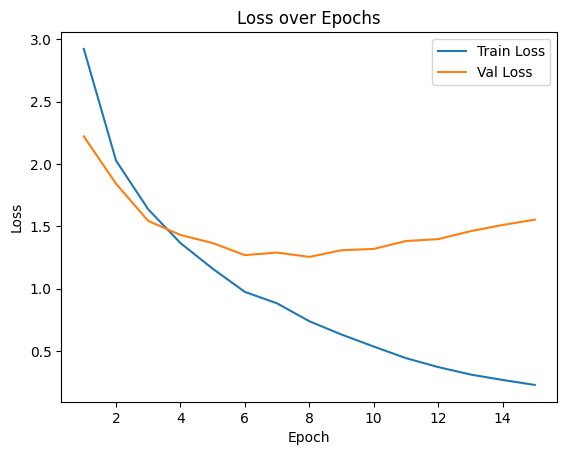

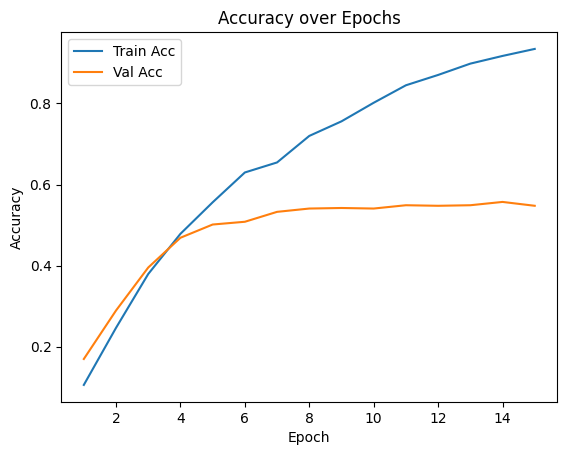

Submission saved.


In [ ]:
import pandas as pd
import re
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchtext.vocab import vocab
from itertools import permutations
from sklearn.model_selection import train_test_split

# 1. 데이터 로드 및 전처리

df = pd.read_csv("train.csv")
perm_list = list(permutations([0, 1, 2, 3]))
df["sentences"] = df.apply(lambda r: [r[f"sentence_{i}"] for i in range(4)], axis=1)
df["label"] = df.apply(lambda r: [r[f"answer_{i}"] for i in range(4)], axis=1)
df["class_id"] = df["label"].apply(lambda x: perm_list.index(tuple(x)))

# Stratified split & shuffle
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    shuffle=True,
    stratify=df["class_id"]
)
val_ids = val_df["ID"].tolist()

# 2. 토크나이즈 & Vocab

def tokenize(text): return re.findall(r"\w+", text.lower())
all_tokens = [t for sents in df["sentences"] for sent in sents for t in tokenize(sent)]
counter = Counter(all_tokens)
vocab_obj = vocab(counter, specials=["<pad>", "<unk>"])
vocab_obj.set_default_index(vocab_obj["<unk>"])

def numericalize(text): return [vocab_obj[w] for w in tokenize(text)]

# 3. Dataset

class SentenceOrderDataset(Dataset):
    def __init__(self, df, max_len=30):
        self.sentences = df["sentences"].tolist()
        self.labels = df["class_id"].tolist()
        self.max_len = max_len
    def __len__(self): return len(self.sentences)
    def pad(self, tokens):
        t = tokens[:self.max_len]
        return t + [vocab_obj["<pad>"]] * (self.max_len - len(t))
    def __getitem__(self, idx):
        enc = [self.pad(numericalize(s)) for s in self.sentences[idx]]
        return torch.tensor(enc), torch.tensor(self.labels[idx])

train_ds = SentenceOrderDataset(train_df)
val_ds   = SentenceOrderDataset(val_df)

# 4. Sampler for imbalance
counts = Counter(train_df["class_id"])
weights = [1.0/counts[c] for c in train_df["class_id"]]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

# 5. Model

class OrderPredictionModel(nn.Module):
    def __init__(self, vocab_size, e_dim=256, h_dim=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, e_dim, padding_idx=vocab_obj["<pad>"])
        self.lstm  = nn.LSTM(
            e_dim, h_dim, batch_first=True,
            num_layers=2, dropout=0.3, bidirectional=True
        )
        self.fc   = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(h_dim*2*4, 256),
            nn.ReLU(),
            nn.Linear(256, len(perm_list))
        )
    def forward(self, x):
        reps = []
        for i in range(4):
            emb = self.embed(x[:,i])
            _, (h,_) = self.lstm(emb)
            h_cat = torch.cat((h[-2], h[-1]), dim=1)  # bidirectional
            reps.append(h_cat)
        out = torch.cat(reps, dim=1)
        return self.fc(out)

# 6. Training setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OrderPredictionModel(len(vocab_obj)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = 15
for ep in range(1, epochs+1):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    train_acc = correct / total
    avg_tr_loss = total_loss / len(train_loader)

    # validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            out = model(x_val)
            val_loss += criterion(out, y_val).item()
            pred = out.argmax(dim=1)
            correct += (pred == y_val).sum().item()
            total += y_val.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    scheduler.step(avg_val_loss)

    train_losses.append(avg_tr_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {ep:02d} | Train Loss {avg_tr_loss:.4f} | Val Loss {avg_val_loss:.4f} | Val Acc {val_acc:.4f}")

# 7. 시각화

epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.title('Loss over Epochs')
plt.show()

plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, val_accs, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.title('Accuracy over Epochs')
plt.show()

# 8. Inference & Submit
model.eval()
preds = []
with torch.no_grad():
    for x, _ in val_loader:
        x = x.to(device)
        out = model(x)
        preds.extend(out.argmax(dim=1).cpu().tolist())

orders = [perm_list[i] for i in preds]
sub = pd.DataFrame({"ID": val_ids,
                    "answer_0":[o[0] for o in orders],
                    "answer_1":[o[1] for o in orders],
                    "answer_2":[o[2] for o in orders],
                    "answer_3":[o[3] for o in orders]})
sub.to_csv("submission2.csv", index=False)
print("Submission saved.")

## 정답률 높이기 위해서 

✅ Bidirectional=True 추가

✅ num_layers=2, dropout=0.3 적용

✅ hidden_dim * 2에 맞게 FC 레이어 수정

✅ Dropout(0.5)으로 regularization 강화 

## 결과.

과적합이 보인다. dropout을 0.6으로 조정할 필요가 있고 epoch수를 15대신 10정도로 줄여볼 필요가 있다.

In [6]:
from itertools import permutations

perm_list = list(permutations([0, 1, 2, 3]))
y_true = val_df["class_id"].tolist()  # 실제 permutation 인덱스
y_pred = preds                        # 예측된 permutation 인덱스

# 상위 5개 결과 비교
for i in range(5):
    id_ = val_ids[i]
    true_perm = perm_list[y_true[i]]
    pred_perm = perm_list[y_pred[i]]
    print(f"📌 ID: {id_}")
    print(f"   🔹 실제 순서: {true_perm}")
    print(f"   🔸 예측 순서: {pred_perm}")
    print()

📌 ID: TRAIN_1386
   🔹 실제 순서: (0, 1, 2, 3)
   🔸 예측 순서: (0, 1, 2, 3)

📌 ID: TRAIN_5907
   🔹 실제 순서: (0, 2, 1, 3)
   🔸 예측 순서: (0, 2, 3, 1)

📌 ID: TRAIN_3016
   🔹 실제 순서: (3, 0, 1, 2)
   🔸 예측 순서: (3, 0, 1, 2)

📌 ID: TRAIN_4184
   🔹 실제 순서: (3, 2, 1, 0)
   🔸 예측 순서: (2, 1, 3, 0)

📌 ID: TRAIN_2483
   🔹 실제 순서: (3, 2, 1, 0)
   🔸 예측 순서: (3, 2, 1, 0)



## 결과를 확인해보니 실제순서와 정확히 예측한것도 있지만 다르게 예측한것도 있다.

In [7]:
from scipy.stats import kendalltau

for i in range(5):
    true_perm = perm_list[y_true[i]]
    pred_perm = perm_list[y_pred[i]]
    tau, _ = kendalltau(true_perm, pred_perm)
    print(f"ID: {val_ids[i]}")
    print(f"  🔹 실제: {true_perm}")
    print(f"  🔸 예측: {pred_perm}")
    print(f"  ✅ 유사도(Kendall tau): {tau:.2f}")
    print()

ID: TRAIN_1386
  🔹 실제: (0, 1, 2, 3)
  🔸 예측: (0, 1, 2, 3)
  ✅ 유사도(Kendall tau): 1.00

ID: TRAIN_5907
  🔹 실제: (0, 2, 1, 3)
  🔸 예측: (0, 2, 3, 1)
  ✅ 유사도(Kendall tau): 0.00

ID: TRAIN_3016
  🔹 실제: (3, 0, 1, 2)
  🔸 예측: (3, 0, 1, 2)
  ✅ 유사도(Kendall tau): 1.00

ID: TRAIN_4184
  🔹 실제: (3, 2, 1, 0)
  🔸 예측: (2, 1, 3, 0)
  ✅ 유사도(Kendall tau): 0.33

ID: TRAIN_2483
  🔹 실제: (3, 2, 1, 0)
  🔸 예측: (3, 2, 1, 0)
  ✅ 유사도(Kendall tau): 1.00



## 테스트 하는 코드

In [ ]:
# ✅ Step 1. test.csv 불러오기
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchtext.vocab import vocab
from collections import Counter
import re
from itertools import permutations
import pickle

# ✅ vocab 불러오기
with open("vocab.pkl", "rb") as f:
    vocab_obj = pickle.load(f)

# 고정된 순열 목록
perm_list = list(permutations([0, 1, 2, 3]))

def tokenize(text): return re.findall(r"\w+", text.lower())
def numericalize(text): return [vocab_obj[token] for token in tokenize(text)]

# test 데이터 전처리
test_df = pd.read_csv("test.csv")
test_df["sentences"] = test_df.apply(lambda r: [r[f"sentence_{i}"] for i in range(4)], axis=1)
test_ids = test_df["ID"].tolist()

# ✅ Step 2. Dataset 정의
class TestDataset(Dataset):
    def __init__(self, df, max_len=30):
        self.sentences = df["sentences"].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def pad(self, tokens):
        tokens = tokens[:self.max_len]
        return tokens + [vocab_obj['<pad>']] * (self.max_len - len(tokens))

    def __getitem__(self, idx):
        encoded = [self.pad(numericalize(sent)) for sent in self.sentences[idx]]
        return torch.tensor(encoded)

# ✅ Step 3. DataLoader 준비
test_dataset = TestDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ✅ Step 4. 예측
model.eval()
test_preds = []
with torch.no_grad():
    for x in tqdm(test_loader):
        x = x.to(device)
        out = model(x)
        pred = out.argmax(dim=1)
        test_preds.extend(pred.cpu().tolist())

# ✅ Step 5. 결과 변환 및 저장
test_orders = [perm_list[i] for i in test_preds]
submission = pd.DataFrame({
    "ID": test_ids,
    "answer_0": [p[0] for p in test_orders],
    "answer_1": [p[1] for p in test_orders],
    "answer_2": [p[2] for p in test_orders],
    "answer_3": [p[3] for p in test_orders]
})

submission.to_csv("submission_test.csv", index=False)
print("✅ test 예측 결과 저장 완료: submission_test.csv")


100%|██████████| 56/56 [00:08<00:00,  6.65it/s]

✅ test 예측 결과 저장 완료: submission_test.csv


## 모델 저장하는 코드

Epoch 01 | Train Loss 3.1514 | Val Loss 2.8543 | Val Acc 0.1481
Epoch 02 | Train Loss 2.2160 | Val Loss 1.9185 | Val Acc 0.2459
Epoch 03 | Train Loss 1.7217 | Val Loss 1.5765 | Val Acc 0.3886
Epoch 04 | Train Loss 1.4421 | Val Loss 1.4644 | Val Acc 0.4511
Epoch 05 | Train Loss 1.2387 | Val Loss 1.3915 | Val Acc 0.4660
Epoch 06 | Train Loss 1.0717 | Val Loss 1.3007 | Val Acc 0.5204
Epoch 07 | Train Loss 0.9546 | Val Loss 1.3450 | Val Acc 0.5068
Epoch 08 | Train Loss 0.8305 | Val Loss 1.3186 | Val Acc 0.5408
Epoch 09 | Train Loss 0.7314 | Val Loss 1.3350 | Val Acc 0.5625
Epoch 10 | Train Loss 0.6236 | Val Loss 1.3218 | Val Acc 0.5625


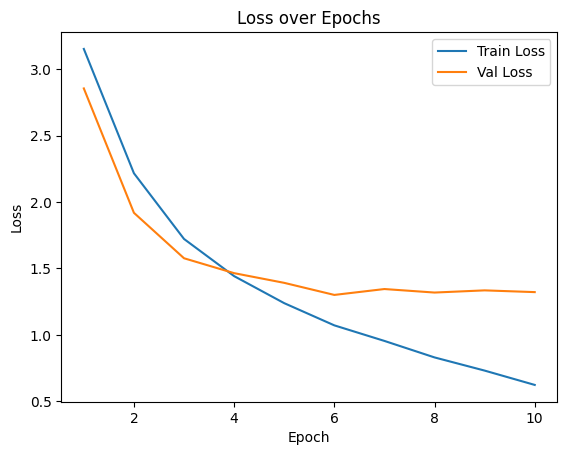

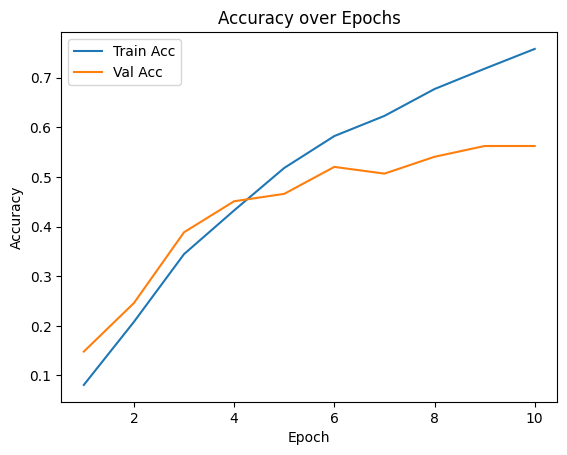

모델과 vocab 저장 완료.
Submission saved.


In [3]:
import pandas as pd
import re
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchtext.vocab import vocab
from itertools import permutations
from sklearn.model_selection import train_test_split

# 1. 데이터 로드 및 전처리

df = pd.read_csv("train.csv")
perm_list = list(permutations([0, 1, 2, 3]))
df["sentences"] = df.apply(lambda r: [r[f"sentence_{i}"] for i in range(4)], axis=1)
df["label"] = df.apply(lambda r: [r[f"answer_{i}"] for i in range(4)], axis=1)
df["class_id"] = df["label"].apply(lambda x: perm_list.index(tuple(x)))

# Stratified split & shuffle
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    shuffle=True,
    stratify=df["class_id"]
)
val_ids = val_df["ID"].tolist()

# 2. 토크나이즈 & Vocab

def tokenize(text): return re.findall(r"\w+", text.lower())
all_tokens = [t for sents in df["sentences"] for sent in sents for t in tokenize(sent)]
counter = Counter(all_tokens)
vocab_obj = vocab(counter, specials=["<pad>", "<unk>"])
vocab_obj.set_default_index(vocab_obj["<unk>"])

def numericalize(text): return [vocab_obj[w] for w in tokenize(text)]

# 3. Dataset

class SentenceOrderDataset(Dataset):
    def __init__(self, df, max_len=30):
        self.sentences = df["sentences"].tolist()
        self.labels = df["class_id"].tolist()
        self.max_len = max_len
    def __len__(self): return len(self.sentences)
    def pad(self, tokens):
        t = tokens[:self.max_len]
        return t + [vocab_obj["<pad>"]] * (self.max_len - len(t))
    def __getitem__(self, idx):
        enc = [self.pad(numericalize(s)) for s in self.sentences[idx]]
        return torch.tensor(enc), torch.tensor(self.labels[idx])

train_ds = SentenceOrderDataset(train_df)
val_ds   = SentenceOrderDataset(val_df)

# 4. Sampler for imbalance
counts = Counter(train_df["class_id"])
weights = [1.0/counts[c] for c in train_df["class_id"]]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

# 5. Model

class OrderPredictionModel(nn.Module):
    def __init__(self, vocab_size, e_dim=256, h_dim=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, e_dim, padding_idx=vocab_obj["<pad>"])
        self.lstm  = nn.LSTM(
            e_dim, h_dim, batch_first=True,
            num_layers=2, dropout=0.6, bidirectional=True
        )
        self.fc   = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(h_dim*2*4, 256),
            nn.ReLU(),
            nn.Linear(256, len(perm_list))
        )
    def forward(self, x):
        reps = []
        for i in range(4):
            emb = self.embed(x[:,i])
            _, (h,_) = self.lstm(emb)
            h_cat = torch.cat((h[-2], h[-1]), dim=1)  # bidirectional
            reps.append(h_cat)
        out = torch.cat(reps, dim=1)
        return self.fc(out)

# 6. Training setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OrderPredictionModel(len(vocab_obj)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = 10
for ep in range(1, epochs+1):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    train_acc = correct / total
    avg_tr_loss = total_loss / len(train_loader)

    # validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            out = model(x_val)
            val_loss += criterion(out, y_val).item()
            pred = out.argmax(dim=1)
            correct += (pred == y_val).sum().item()
            total += y_val.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    scheduler.step(avg_val_loss)

    train_losses.append(avg_tr_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {ep:02d} | Train Loss {avg_tr_loss:.4f} | Val Loss {avg_val_loss:.4f} | Val Acc {val_acc:.4f}")

# 7. 시각화

epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.title('Loss over Epochs')
plt.show()

plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, val_accs, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.title('Accuracy over Epochs')
plt.show()

# 8. 저장
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab_obj, f)
torch.save(model.state_dict(), "model.pth")
print("모델과 vocab 저장 완료.")

# 9. Inference & Submit
model.eval()
preds = []
with torch.no_grad():
    for x, _ in val_loader:
        x = x.to(device)
        out = model(x)
        preds.extend(out.argmax(dim=1).cpu().tolist())

orders = [perm_list[i] for i in preds]
sub = pd.DataFrame({"ID": val_ids,
                    "answer_0":[o[0] for o in orders],
                    "answer_1":[o[1] for o in orders],
                    "answer_2":[o[2] for o in orders],
                    "answer_3":[o[3] for o in orders]})
sub.to_csv("submission3.csv", index=False)
print("Submission saved.")
